# 딥페이크 탐지 모델 학습 - ViT 기반

이 노트북은 대회 baseline 구조를 따라 작성되었습니다.

## 데이터 경로
- Image: `/home/lee/Final_project/original/image/`
- Video: `/home/lee/Final_project/original/video/`

## 라벨
- 0: Real (진짜)
- 1: Fake (가짜/딥페이크)

## 1. 필요 라이브러리 설치

In [6]:
!pip install evaluate datasets accelerate
!pip install transformers==4.30

## 2. 라이브러리 Import

In [7]:
import warnings
warnings.filterwarnings("ignore")

import gc
import os
import glob
import cv2
import numpy as np
import pandas as pd
import itertools
from collections import Counter
from pathlib import Path
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import evaluate
from datasets import Dataset, Features, Value, ClassLabel as HFClassLabel, Image as HFImage
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)
from PIL import Image as PILImage
from PIL import ImageFile

# Enable loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

print("✓ 라이브러리 임포트 완료")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")

✓ 라이브러리 임포트 완료
PyTorch version: 2.7.1+cu126
CUDA available: True
Device: NVIDIA GeForce RTX 4060


## 3. 데이터 로드

이미지와 비디오 파일 경로를 수집합니다.

In [8]:
# ====== 경로 설정 ======
IMAGE_ROOT = "/home/lee/Final_project/original/image"
VIDEO_ROOT = "/home/lee/Final_project/original/video"

# 확장자
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
VID_EXTS = (".mp4", ".avi", ".mov", ".mkv", ".webm")

# ====== 데이터 소스 정의 ======
# 0=Real(진짜), 1=Fake(가짜)
SOURCES = [
    # 이미지
    {"root": os.path.join(IMAGE_ROOT, "ai_people"), "label": 1, "type": "image"},
    {"root": os.path.join(IMAGE_ROOT, "korea_image"), "label": 0, "type": "image"},
    
    # 비디오
    {"root": os.path.join(VIDEO_ROOT, "ai_video"), "label": 1, "type": "video"},
    {"root": os.path.join(VIDEO_ROOT, "Celeb-DF-v3/Celeb-fake"), "label": 1, "type": "video"},
    {"root": os.path.join(VIDEO_ROOT, "Celeb-DF-v3/Celeb-real"), "label": 0, "type": "video"},
    {"root": os.path.join(VIDEO_ROOT, "FaceForensics++_C23/ff_fake"), "label": 1, "type": "video"},
    {"root": os.path.join(VIDEO_ROOT, "FaceForensics++_C23/ff_real"), "label": 0, "type": "video"},
    {"root": os.path.join(VIDEO_ROOT, "kodf/kodf fake"), "label": 1, "type": "video"},
    {"root": os.path.join(VIDEO_ROOT, "kodf/kodf real/Orginal"), "label": 0, "type": "video"},
]

print("데이터 소스 설정 완료")

데이터 소스 설정 완료


In [9]:
# ====== 파일 스캔 ======
def scan_files(root, file_type, label):
    """디렉토리에서 파일 경로 수집"""
    if not os.path.isdir(root):
        print(f"[SKIP] {root} (폴더 없음)")
        return []
    
    exts = IMG_EXTS if file_type == "image" else VID_EXTS
    files = []
    
    for ext in exts:
        pattern = os.path.join(root, "**", f"*{ext}")
        found = glob.glob(pattern, recursive=True)
        files.extend(found)
    
    result = [{"path": f, "label": label, "type": file_type} for f in files]
    print(f"[OK] {root} -> {len(result)} files")
    return result

# 전체 파일 수집
print("\n=== 파일 스캔 시작 ===")
all_files = []
for source in SOURCES:
    files = scan_files(source["root"], source["type"], source["label"])
    all_files.extend(files)

if len(all_files) == 0:
    raise ValueError("파일을 찾을 수 없습니다!")

# DataFrame 생성
df_files = pd.DataFrame(all_files).drop_duplicates(subset=["path"]).reset_index(drop=True)

print(f"\n=== 스캔 완료 ===")
print(f"총 파일 수: {len(df_files)}")
print(f"\n타입별 분포:")
print(df_files["type"].value_counts())
print(f"\n라벨별 분포:")
print(df_files["label"].value_counts())


=== 파일 스캔 시작 ===
[OK] /home/lee/Final_project/original/image/ai_people -> 14 files
[OK] /home/lee/Final_project/original/image/korea_image -> 2451 files
[OK] /home/lee/Final_project/original/video/ai_video -> 8 files
[OK] /home/lee/Final_project/original/video/Celeb-DF-v3/Celeb-fake -> 27197 files
[OK] /home/lee/Final_project/original/video/Celeb-DF-v3/Celeb-real -> 590 files
[OK] /home/lee/Final_project/original/video/FaceForensics++_C23/ff_fake -> 6000 files
[OK] /home/lee/Final_project/original/video/FaceForensics++_C23/ff_real -> 1000 files
[OK] /home/lee/Final_project/original/video/kodf/kodf fake -> 352 files
[OK] /home/lee/Final_project/original/video/kodf/kodf real/Orginal -> 108 files

=== 스캔 완료 ===
총 파일 수: 37720

타입별 분포:
type
video    35255
image     2465
Name: count, dtype: int64

라벨별 분포:
label
1    33571
0     4149
Name: count, dtype: int64


## 4. 비디오 프레임 추출 및 이미지 로드

비디오에서 중앙 프레임을 추출하고, 이미지는 그대로 로드합니다.

In [10]:
def extract_center_frame(video_path):
    """비디오에서 중앙 프레임 추출"""
    try:
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            return None

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0:
            cap.release()
            return None

        # 중앙 프레임으로 이동
        center_idx = total_frames // 2
        cap.set(cv2.CAP_PROP_POS_FRAMES, center_idx)

        ret, frame = cap.read()
        cap.release()

        if not ret or frame is None:
            return None

        # BGR -> RGB 변환
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return PILImage.fromarray(frame_rgb)

    except Exception as e:
        print(f"Error: {video_path} - {e}")
        return None

print("\n=== 이미지/비디오 처리 시작 ===")

# 비디오와 이미지 분리
video_df = df_files[df_files['type'] == 'video'].copy()
image_df = df_files[df_files['type'] == 'image'].copy()

print(f"원본 비디오 파일: {len(video_df)}개")
print(f"원본 이미지 파일: {len(image_df)}개")

# ====== 비디오 샘플링 전략 ======
# 1. ai_video: 전부 사용
# 2. kodf: 전부 사용
# 3. Celeb-DF + FaceForensics++: 총 460개, 각 소스별 평등하게

# 소스별로 비디오 분류
ai_video_df = video_df[video_df['path'].str.contains('/ai_video/')].copy()
kodf_fake_df = video_df[video_df['path'].str.contains('/kodf/kodf fake')].copy()
kodf_real_df = video_df[video_df['path'].str.contains('/kodf/kodf real')].copy()
celeb_fake_df = video_df[video_df['path'].str.contains('/Celeb-DF-v3/Celeb-fake')].copy()
celeb_real_df = video_df[video_df['path'].str.contains('/Celeb-DF-v3/Celeb-real')].copy()
ff_fake_df = video_df[video_df['path'].str.contains('/FaceForensics\\+\\+_C23/ff_fake')].copy()
ff_real_df = video_df[video_df['path'].str.contains('/FaceForensics\\+\\+_C23/ff_real')].copy()

print("\n=== 비디오 소스별 분포 ===")
print(f"ai_video: {len(ai_video_df)}개 (전부 사용)")
print(f"kodf fake: {len(kodf_fake_df)}개 (전부 사용)")
print(f"kodf real: {len(kodf_real_df)}개 (전부 사용)")
print(f"Celeb-fake: {len(celeb_fake_df)}개")
print(f"Celeb-real: {len(celeb_real_df)}개")
print(f"FF++ fake: {len(ff_fake_df)}개")
print(f"FF++ real: {len(ff_real_df)}개")

# Celeb-DF + FaceForensics++ 샘플링
# 4개 소스에서 각각 115개씩 (총 460개)
LARGE_DATASET_SAMPLE_SIZE = 115

sampled_dfs = []
for df_name, df in [('Celeb-fake', celeb_fake_df),
                     ('Celeb-real', celeb_real_df),
                     ('FF++ fake', ff_fake_df),
                     ('FF++ real', ff_real_df)]:
    if len(df) > LARGE_DATASET_SAMPLE_SIZE:
        sampled = df.sample(n=LARGE_DATASET_SAMPLE_SIZE, random_state=42).reset_index(drop=True)
        print(f"{df_name}: {len(df)}개 → {len(sampled)}개 샘플링")
    else:
        sampled = df
        print(f"{df_name}: {len(df)}개 (전부 사용)")
    sampled_dfs.append(sampled)

# 최종 비디오 데이터프레임 결합
video_df_final = pd.concat([
    ai_video_df,
    kodf_fake_df,
    kodf_real_df,
] + sampled_dfs, ignore_index=True)

print(f"\n최종 비디오: {len(video_df_final)}개")
print(f"  - ai_video: {len(ai_video_df)}개")
print(f"  - kodf: {len(kodf_fake_df) + len(kodf_real_df)}개")
print(f"  - Celeb-DF + FF++: {sum(len(df) for df in sampled_dfs)}개")

# 프레임 추출 및 이미지 로드
dataset_rows = []

# 비디오 처리
print("\n비디오 프레임 추출 중...")
for idx, row in tqdm(video_df_final.iterrows(), total=len(video_df_final), desc="Video"):
    frame = extract_center_frame(row['path'])
    if frame is not None:
        dataset_rows.append({
            'image': frame,
            'label': row['label'],
            'source': row['path']
        })

print(f"추출된 프레임: {len(dataset_rows)}개")

# 이미지 처리
print("\n이미지 로드 중...")
for idx, row in tqdm(image_df.iterrows(), total=len(image_df), desc="Image"):
    try:
        img = PILImage.open(row['path']).convert('RGB')
        dataset_rows.append({
            'image': img,
            'label': row['label'],
            'source': row['path']
        })
    except Exception as e:
        print(f"Error: {row['path']} - {e}")

# 최종 DataFrame
df_dataset = pd.DataFrame(dataset_rows)

print(f"\n=== 데이터 준비 완료 ===")
print(f"총 샘플 수: {len(df_dataset)}")
print(f"\n라벨 분포:")
print(df_dataset['label'].value_counts().sort_index())
print(f"  Real (0): {(df_dataset['label']==0).sum()}개")
print(f"  Fake (1): {(df_dataset['label']==1).sum()}개")


=== 이미지/비디오 처리 시작 ===
원본 비디오 파일: 35255개
원본 이미지 파일: 2465개

=== 비디오 소스별 분포 ===
ai_video: 8개 (전부 사용)
kodf fake: 352개 (전부 사용)
kodf real: 108개 (전부 사용)
Celeb-fake: 27197개
Celeb-real: 590개
FF++ fake: 6000개
FF++ real: 1000개
Celeb-fake: 27197개 → 115개 샘플링
Celeb-real: 590개 → 115개 샘플링
FF++ fake: 6000개 → 115개 샘플링
FF++ real: 1000개 → 115개 샘플링

최종 비디오: 928개
  - ai_video: 8개
  - kodf: 460개
  - Celeb-DF + FF++: 460개

비디오 프레임 추출 중...


Video: 100%|██████████| 928/928 [01:21<00:00, 11.43it/s]


추출된 프레임: 928개

이미지 로드 중...


Image: 100%|██████████| 2465/2465 [00:26<00:00, 91.41it/s] 


=== 데이터 준비 완료 ===
총 샘플 수: 3393

라벨 분포:
label
0    2789
1     604
Name: count, dtype: int64
  Real (0): 2789개
  Fake (1): 604개


## 5. 데이터셋 분할 (Train / Val / Test)

60% Train / 20% Validation / 20% Test

In [11]:
print("\n=== 데이터셋 분할 ===")

# Train (80%) / Val (20%)
# 대회에서 테스트셋이 따로 제공되므로 모든 데이터를 학습에 사용
train_df, val_df = train_test_split(
    df_dataset,
    test_size=0.2,
    random_state=42,
    stratify=df_dataset['label']
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train: {len(train_df)} (Real: {(train_df['label']==0).sum()}, Fake: {(train_df['label']==1).sum()})")
print(f"Val:   {len(val_df)} (Real: {(val_df['label']==0).sum()}, Fake: {(val_df['label']==1).sum()})")
print(f"\n✓ 전체 데이터의 100%를 학습에 사용 (Test 분할 없음)")


=== 데이터셋 분할 ===
Train: 2714 (Real: 2231, Fake: 483)
Val:   679 (Real: 558, Fake: 121)

✓ 전체 데이터의 100%를 학습에 사용 (Test 분할 없음)


## 6. HuggingFace Dataset 생성

ViT Trainer를 사용하기 위해 HuggingFace Dataset 형식으로 변환합니다.

In [12]:
# 라벨 매핑 정의
labels_list = ['Real', 'Fake']
label2id = {'Real': 0, 'Fake': 1}
id2label = {0: 'Real', 1: 'Fake'}

print("라벨 매핑:")
print(f"  {id2label}")

# HuggingFace Dataset으로 변환
def df_to_hf_dataset(df):
    """Pandas DataFrame을 HuggingFace Dataset으로 변환"""
    data = {
        'image': df['image'].tolist(),
        'label': df['label'].tolist()
    }
    return Dataset.from_dict(data)

print("\nHuggingFace Dataset 생성 중...")
train_dataset = df_to_hf_dataset(train_df)
val_dataset = df_to_hf_dataset(val_df)

# ClassLabel로 캐스팅
class_labels = HFClassLabel(num_classes=2, names=labels_list)
train_dataset = train_dataset.cast_column('label', class_labels)
val_dataset = val_dataset.cast_column('label', class_labels)

print(f"\n✓ HuggingFace Dataset 생성 완료")
print(f"  Train: {len(train_dataset)}")
print(f"  Val:   {len(val_dataset)}")

라벨 매핑:
  {0: 'Real', 1: 'Fake'}

HuggingFace Dataset 생성 중...


Casting the dataset: 100%|██████████| 679/679 [00:00<00:00, 44857.10 examples/s]


✓ HuggingFace Dataset 생성 완료
  Train: 2714
  Val:   679


## 7. ViT 모델 및 전처리 설정

In [13]:
# ViT 모델 선택
model_str = "google/vit-base-patch16-224-in21k"

# Processor 로드
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

print(f"모델: {model_str}")
print(f"이미지 크기: {size}x{size}")
print(f"정규화 - Mean: {image_mean}")
print(f"정규화 - Std: {image_std}")

# Transform 정의
_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(10),
    RandomHorizontalFlip(p=0.5),
    RandomAdjustSharpness(2, p=0.5),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(img.convert("RGB")) for img in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(img.convert("RGB")) for img in examples['image']]
    return examples

# Transform 적용
train_dataset.set_transform(train_transforms)
val_dataset.set_transform(val_transforms)

print("\n✓ Transform 설정 완료")

모델: google/vit-base-patch16-224-in21k
이미지 크기: 224x224
정규화 - Mean: [0.5, 0.5, 0.5]
정규화 - Std: [0.5, 0.5, 0.5]

✓ Transform 설정 완료


In [14]:
# Collate function 정의
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

print("✓ Collate function 정의 완료")

✓ Collate function 정의 완료


In [15]:
# ViT 모델 로드
model = ViTForImageClassification.from_pretrained(
    model_str,
    num_labels=len(labels_list),
    id2label=id2label,
    label2id=label2id
)

trainable_params = model.num_parameters(only_trainable=True) / 1e6
print(f"\n✓ 모델 로드 완료")
print(f"학습 가능한 파라미터: {trainable_params:.2f}M")

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ 모델 로드 완료
학습 가능한 파라미터: 85.80M


## 8. 평가 메트릭 정의

In [16]:
# Accuracy 메트릭 로드
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    
    return {"accuracy": acc_score}

print("✓ 평가 메트릭 정의 완료")

✓ 평가 메트릭 정의 완료


## 9. 학습 설정 및 실행

In [17]:
from transformers import TrainingArguments, EarlyStoppingCallback

args = TrainingArguments(
    output_dir="./deepfake_vit_model",
    logging_dir="./logs",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    warmup_steps=100,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",   # ← compute_metrics 키 이름과 동일
    greater_is_better=True,             # F1은 클수록 좋음
    save_total_limit=2,
    report_to="none",
    fp16=True,
)
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # per-class F1 (정의에 맞게)
    f1_pos = f1_score(labels, preds, pos_label=1, average="binary")  # Fake(1)
    f1_neg = f1_score(labels, preds, pos_label=0, average="binary")  # Real(0)

    macro_f1 = (f1_pos + f1_neg) / 2.0  # 문서의 수식 그대로
    acc = accuracy_score(labels, preds)

    return {
        "macro_f1": macro_f1,  # ← 이 키가 best 모델 기준이 됨
        "f1_pos": f1_pos,
        "f1_neg": f1_neg,
        "accuracy": acc,
    }
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=1e-4)],
)


In [18]:
# Trainer 생성
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

print("✓ Trainer 생성 완료")

✓ Trainer 생성 완료


In [19]:
# 학습 전 평가
print("\n=== 학습 전 평가 ===")
eval_results = trainer.evaluate()
print(eval_results)


=== 학습 전 평가 ===


{'eval_loss': 0.6843013763427734, 'eval_macro_f1': 0.4808442291508447, 'eval_f1_pos': 0.2766990291262136, 'eval_f1_neg': 0.6849894291754758, 'eval_accuracy': 0.561119293078056, 'eval_runtime': 9.6086, 'eval_samples_per_second': 70.666, 'eval_steps_per_second': 2.29}


In [20]:
# 학습 시작
print("\n=== 학습 시작 ===")
train_results = trainer.train()
print("\n✓ 학습 완료")
print(train_results)


=== 학습 시작 ===


Epoch,Training Loss,Validation Loss,Macro F1,F1 Pos,F1 Neg,Accuracy
1,No log,0.216187,0.824040,0.707424,0.940655,0.901325
2,No log,0.171659,0.872517,0.795539,0.949495,0.918999
3,No log,0.168608,0.842852,0.737778,0.947926,0.913108
4,No log,0.170833,0.831858,0.714976,0.948740,0.913108
5,No log,0.155870,0.868227,0.780702,0.955752,0.926362
6,0.192300,0.203458,0.819718,0.693069,0.946367,0.908689
7,0.192300,0.175146,0.854611,0.756757,0.952465,0.920471
8,0.192300,0.172712,0.858833,0.764444,0.953222,0.921944
9,0.192300,0.169134,0.863183,0.771300,0.955066,0.924890
10,0.192300,0.192488,0.853560,0.753488,0.953631,0.921944



✓ 학습 완료
TrainOutput(global_step=1700, training_loss=0.08352448168922873, metrics={'train_runtime': 1372.1076, 'train_samples_per_second': 39.56, 'train_steps_per_second': 1.239, 'total_flos': 4.206265196280054e+18, 'train_loss': 0.08352448168922873, 'epoch': 20.0})


In [21]:
# 학습 후 평가
print("\n=== 학습 후 평가 (Validation Set) ===")
eval_results = trainer.evaluate()
print(eval_results)


=== 학습 후 평가 (Validation Set) ===


{'eval_loss': 0.19034871459007263, 'eval_macro_f1': 0.8734979040521659, 'eval_f1_pos': 0.7894736842105263, 'eval_f1_neg': 0.9575221238938054, 'eval_accuracy': 0.9293078055964654, 'eval_runtime': 9.4303, 'eval_samples_per_second': 72.002, 'eval_steps_per_second': 2.333, 'epoch': 20.0}


## 10. 테스트 세트 평가

In [22]:
# Validation 세트 최종 평가
print("\n=== Validation Set 최종 평가 ===")
val_results = trainer.predict(val_dataset)
print(val_results.metrics)


=== Validation Set 최종 평가 ===
{'test_loss': 0.19034871459007263, 'test_macro_f1': 0.8734979040521659, 'test_f1_pos': 0.7894736842105263, 'test_f1_neg': 0.9575221238938054, 'test_accuracy': 0.9293078055964654, 'test_runtime': 9.2828, 'test_samples_per_second': 73.146, 'test_steps_per_second': 2.37}


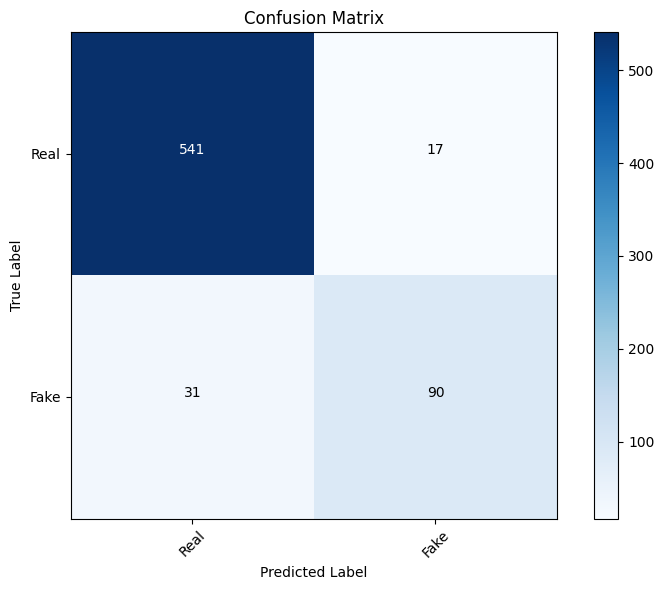


Validation Accuracy: 0.9293
Validation F1 Score: 0.8735

Classification Report:
              precision    recall  f1-score   support

        Real     0.9458    0.9695    0.9575       558
        Fake     0.8411    0.7438    0.7895       121

    accuracy                         0.9293       679
   macro avg     0.8935    0.8567    0.8735       679
weighted avg     0.9271    0.9293    0.9276       679



In [23]:
# Confusion Matrix 및 분류 리포트
y_true = val_results.label_ids
y_pred = val_results.predictions.argmax(1)

# Confusion Matrix 시각화
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, labels_list)

# 메트릭 출력
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\nValidation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

## 11. 모델 저장

In [24]:
# 모델 저장
save_dir = "./deepfake_vit_final"
trainer.save_model(save_dir)
processor.save_pretrained(save_dir)

print(f"\n✓ 모델 저장 완료: {save_dir}")
print("\n저장된 파일:")
for file in os.listdir(save_dir):
    print(f"  - {file}")


✓ 모델 저장 완료: ./deepfake_vit_final

저장된 파일:
  - config.json
  - preprocessor_config.json
  - pytorch_model.bin
  - training_args.bin


## 12. 추론 테스트 (샘플)


=== 샘플 추론 ===
True Label: Real
Predictions:
  Real: 0.9951
  Fake: 0.0049


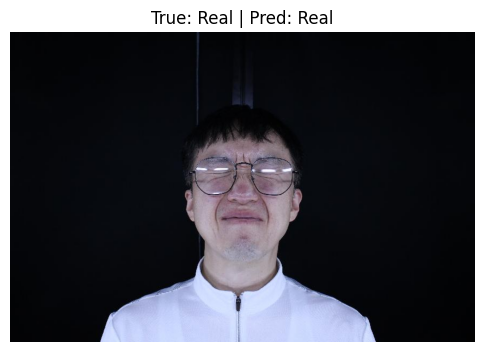

In [25]:
# 추론 파이프라인 생성
from transformers import pipeline

pipe = pipeline('image-classification', model=save_dir, device=0 if torch.cuda.is_available() else -1)

# Validation 샘플 추론
sample_idx = 0
sample_image = val_dataset[sample_idx]['image']
true_label = id2label[val_dataset[sample_idx]['label']]

# 추론 실행
predictions = pipe(sample_image)

print(f"\n=== 샘플 추론 ===")
print(f"True Label: {true_label}")
print(f"Predictions:")
for pred in predictions:
    print(f"  {pred['label']}: {pred['score']:.4f}")

# 이미지 표시
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.title(f"True: {true_label} | Pred: {predictions[0]['label']}")
plt.axis('off')
plt.show()

## ✓ 완료

모델 학습 및 평가가 완료되었습니다!

다음 단계:
1. `task.ipynb`에서 추론 코드 작성
2. 모델 파일을 `./model/` 디렉토리로 복사
3. 대회 제출

## 13. Test 데이터 평가

별도의 test 폴더 데이터로 모델 성능을 평가합니다.

In [26]:
import os 
import glob
# Test 데이터 경로
TEST_ROOT = "/home/lee/Final_project/original/test"

# 확장자 정의 (이전 셀에서 정의된 것과 동일)
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
VID_EXTS = (".mp4", ".avi", ".mov", ".mkv", ".webm")

print("=== Test 데이터 로드 ===")

# 파일명 패턴으로 라벨 추론
def infer_label_from_filename(filename):
    """
    파일명 패턴으로 라벨 추론:
    - _001.확장자 또는 단순 파일명 (E01_C4.jpg) → Real (0)
    - 복잡한 패턴 (숫자_숫자_숫자_숫자.확장자) → Fake (1)
    """
    basename = os.path.basename(filename)
    
    # 이미지 패턴 (E01_C4.jpg 등)
    if basename.startswith('E') and '_C' in basename:
        return 0  # Real
    
    # 비디오 패턴
    # _001.mp4 → Real
    if '_001.' in basename:
        return 0
    
    # 숫자_숫자_숫자_숫자.mp4 → Fake
    parts = basename.split('_')
    if len(parts) >= 4:
        return 1
    
    # 기본값 (확실하지 않은 경우)
    return 0

# Test 파일 스캔
test_files = []
for ext in list(IMG_EXTS) + list(VID_EXTS):
    pattern = os.path.join(TEST_ROOT, f"*{ext}")
    found = glob.glob(pattern)
    test_files.extend(found)

print(f"Test 파일 수: {len(test_files)}")

# 라벨 추론 및 DataFrame 생성
test_data = []
for file_path in test_files:
    label = infer_label_from_filename(file_path)
    file_type = 'image' if file_path.lower().endswith(IMG_EXTS) else 'video'
    test_data.append({
        'path': file_path,
        'label': label,
        'type': file_type
    })

test_df = pd.DataFrame(test_data)

print(f"\n파일 타입별 분포:")
print(test_df['type'].value_counts())
print(f"\n라벨 분포 (추론):")
print(test_df['label'].value_counts())
print(f"  Real (0): {(test_df['label']==0).sum()}개")
print(f"  Fake (1): {(test_df['label']==1).sum()}개")

=== Test 데이터 로드 ===
Test 파일 수: 301

파일 타입별 분포:
type
video    192
image    109
Name: count, dtype: int64

라벨 분포 (추론):
label
0    152
1    149
Name: count, dtype: int64
  Real (0): 152개
  Fake (1): 149개


In [27]:
# Test 데이터 처리 (프레임 추출 및 이미지 로드)
print("\n=== Test 데이터 처리 ===")

test_dataset_rows = []

# 비디오 처리
test_videos = test_df[test_df['type'] == 'video']
print(f"\n비디오 프레임 추출 중... ({len(test_videos)}개)")
for idx, row in tqdm(test_videos.iterrows(), total=len(test_videos), desc="Test Videos"):
    frame = extract_center_frame(row['path'])
    if frame is not None:
        test_dataset_rows.append({
            'image': frame,
            'label': row['label'],
            'source': row['path']
        })

# 이미지 처리
test_images = test_df[test_df['type'] == 'image']
print(f"\n이미지 로드 중... ({len(test_images)}개)")
for idx, row in tqdm(test_images.iterrows(), total=len(test_images), desc="Test Images"):
    try:
        img = PILImage.open(row['path']).convert('RGB')
        test_dataset_rows.append({
            'image': img,
            'label': row['label'],
            'source': row['path']
        })
    except Exception as e:
        print(f"Error: {row['path']} - {e}")

# Test DataFrame 생성
test_dataset_df = pd.DataFrame(test_dataset_rows)

print(f"\n=== Test 데이터 준비 완료 ===")
print(f"총 샘플 수: {len(test_dataset_df)}")
print(f"  Real (0): {(test_dataset_df['label']==0).sum()}개")
print(f"  Fake (1): {(test_dataset_df['label']==1).sum()}개")


=== Test 데이터 처리 ===

비디오 프레임 추출 중... (192개)


Test Videos: 100%|██████████| 192/192 [00:22<00:00,  8.43it/s]



이미지 로드 중... (109개)


Test Images: 100%|██████████| 109/109 [00:07<00:00, 14.73it/s]


=== Test 데이터 준비 완료 ===
총 샘플 수: 301
  Real (0): 152개
  Fake (1): 149개


In [28]:
# HuggingFace Dataset으로 변환
print("\n=== Test Dataset 생성 ===")
test_hf_dataset = df_to_hf_dataset(test_dataset_df)
test_hf_dataset = test_hf_dataset.cast_column('label', class_labels)

# Transform 적용 (Validation과 동일)
test_hf_dataset.set_transform(val_transforms)

print(f"✓ Test Dataset 생성 완료: {len(test_hf_dataset)}개")


=== Test Dataset 생성 ===


Casting the dataset: 100%|██████████| 301/301 [00:00<00:00, 2561.64 examples/s]

✓ Test Dataset 생성 완료: 301개


In [29]:
# Test 데이터 추론
print("\n=== Test Set 평가 ===")
test_results = trainer.predict(test_hf_dataset)

print("\nTest Metrics:")
print(test_results.metrics)

# 예측 결과 추출
y_true_test = test_results.label_ids
y_pred_test = test_results.predictions.argmax(1)

# 메트릭 계산
test_acc = accuracy_score(y_true_test, y_pred_test)
test_f1 = f1_score(y_true_test, y_pred_test, average='macro')
test_f1_pos = f1_score(y_true_test, y_pred_test, pos_label=1, average='binary')
test_f1_neg = f1_score(y_true_test, y_pred_test, pos_label=0, average='binary')

print(f"\n=== Test 결과 ===")
print(f"Accuracy: {test_acc:.4f}")
print(f"Macro F1: {test_f1:.4f}")
print(f"F1 (Fake): {test_f1_pos:.4f}")
print(f"F1 (Real): {test_f1_neg:.4f}")


=== Test Set 평가 ===



Test Metrics:
{'test_loss': 0.4882422685623169, 'test_macro_f1': 0.8039520891979908, 'test_f1_pos': 0.8065573770491804, 'test_f1_neg': 0.8013468013468013, 'test_accuracy': 0.8039867109634552, 'test_runtime': 11.4333, 'test_samples_per_second': 26.327, 'test_steps_per_second': 0.875}

=== Test 결과 ===
Accuracy: 0.8040
Macro F1: 0.8040
F1 (Fake): 0.8066
F1 (Real): 0.8013



=== Test Confusion Matrix ===


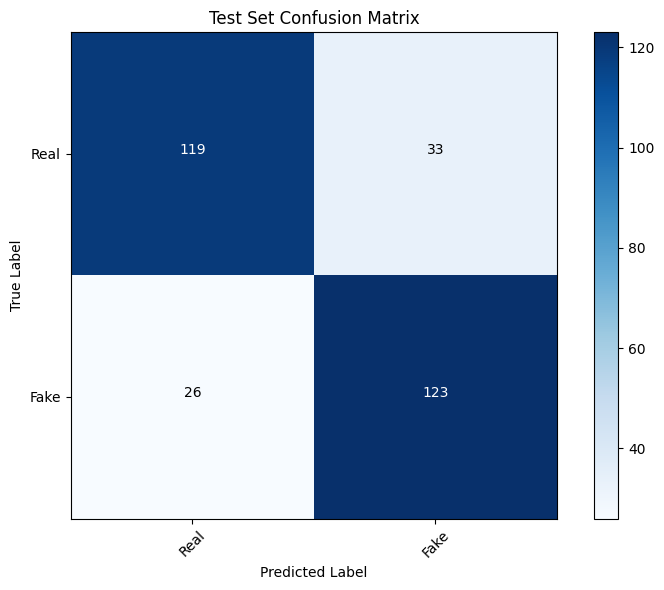


Test Classification Report:
              precision    recall  f1-score   support

        Real     0.8207    0.7829    0.8013       152
        Fake     0.7885    0.8255    0.8066       149

    accuracy                         0.8040       301
   macro avg     0.8046    0.8042    0.8040       301
weighted avg     0.8047    0.8040    0.8039       301



In [30]:
# Test Confusion Matrix 시각화
print("\n=== Test Confusion Matrix ===")

cm_test = confusion_matrix(y_true_test, y_pred_test)
plot_confusion_matrix(cm_test, labels_list, title='Test Set Confusion Matrix')

print("\nTest Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=labels_list, digits=4))


=== 성능 비교 요약 ===

   Dataset  Accuracy  Macro F1  Samples
Validation  0.929308  0.873498      679
      Test  0.803987  0.803952      301


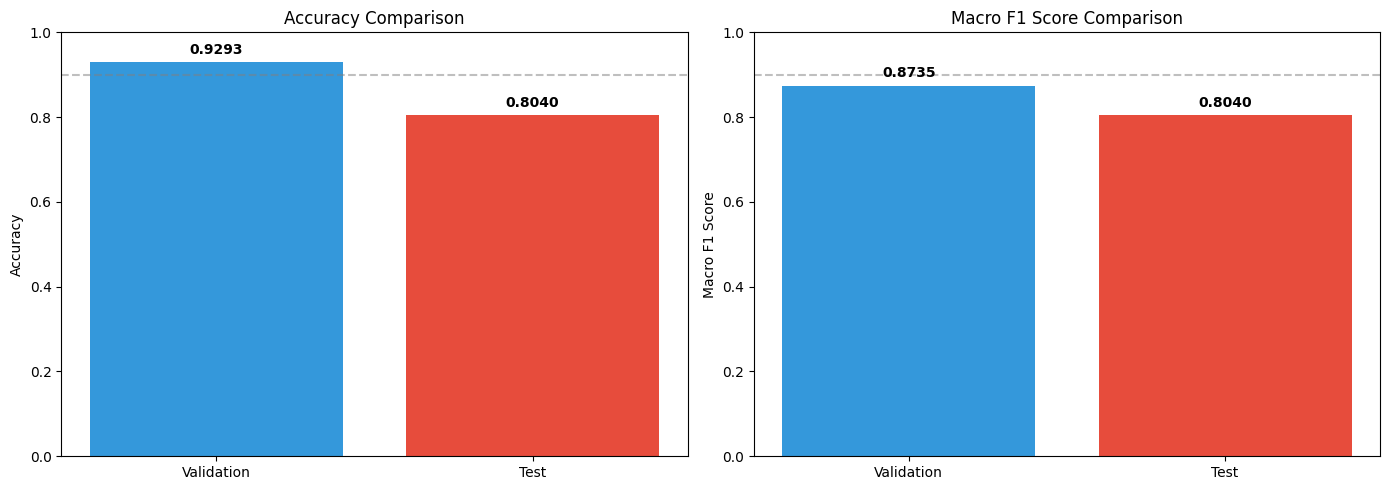


✓ Test 평가 완료!


In [31]:
# Train / Validation / Test 성능 비교
print("\n=== 성능 비교 요약 ===\n")

# Validation 결과 재계산
val_acc = accuracy_score(y_true, y_pred)
val_f1 = f1_score(y_true, y_pred, average='macro')

# 비교 테이블 생성
comparison_df = pd.DataFrame({
    'Dataset': ['Validation', 'Test'],
    'Accuracy': [val_acc, test_acc],
    'Macro F1': [val_f1, test_f1],
    'Samples': [len(y_true), len(y_true_test)]
})

print(comparison_df.to_string(index=False))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy 비교
axes[0].bar(['Validation', 'Test'], [val_acc, test_acc], color=['#3498db', '#e74c3c'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylim([0, 1])
axes[0].axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
for i, (dataset, acc) in enumerate(zip(['Validation', 'Test'], [val_acc, test_acc])):
    axes[0].text(i, acc + 0.02, f'{acc:.4f}', ha='center', fontweight='bold')

# F1 Score 비교
axes[1].bar(['Validation', 'Test'], [val_f1, test_f1], color=['#3498db', '#e74c3c'])
axes[1].set_ylabel('Macro F1 Score')
axes[1].set_title('Macro F1 Score Comparison')
axes[1].set_ylim([0, 1])
axes[1].axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
for i, (dataset, f1) in enumerate(zip(['Validation', 'Test'], [val_f1, test_f1])):
    axes[1].text(i, f1 + 0.02, f'{f1:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Test 평가 완료!")